1. 异步计算
2. 自动并行

In [4]:
import os
import subprocess
import numpy
import torch
from torch import nn
import dltools

In [5]:
# GPU计算
device = dltools.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with dltools.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)

with dltools.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)

numpy: 2.8189 sec
torch: 0.0508 sec


In [9]:
with dltools.Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

Done: 0.1034 sec


In [8]:
x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

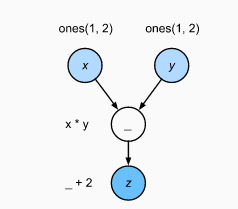

In [10]:
# 基于多GPU的并行计算
devices = dltools.try_all_gpus()
def run(x):
    return [x.mm(x) for _ in range(50)]

x_gpu1 = torch.rand(size=(4000, 4000), device=devices[0])
x_gpu2 = torch.rand(size=(4000, 4000), device=devices[1])


In [ ]:
run(x_gpu1)
run(x_gpu2)  
torch.cuda.synchronize(devices[0])
torch.cuda.synchronize(devices[1])

with d2l.Benchmark('GPU1 time'):
    run(x_gpu1)
    torch.cuda.synchronize(devices[0])

with d2l.Benchmark('GPU2 time'):
    run(x_gpu2)
    torch.cuda.synchronize(devices[1])

GPU1 time: 0.4872 sec
GPU2 time: 0.5076 sec

In [ ]:
with dltools.Benchmark('GPU1 & GPU2'):
    run(x_gpu1)
    run(x_gpu2)
    torch.cuda.synchronize()

GPU1 & GPU2: 0.4918 sec

In [ ]:
# 并行计算与通信
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]

with dltools.Benchmark('在GPU1上运行'):
    y = run(x_gpu1)
    torch.cuda.synchronize()

with dltools.Benchmark('复制到CPU'):
    y_cpu = copy_to_cpu(y)
    torch.cuda.synchronize()

在GPU1上运行: 0.4904 sec
复制到CPU: 2.3745 sec

In [ ]:
with dltools.Benchmark('在GPU1上运行并复制到CPU'):
    y = run(x_gpu1)
    y_cpu = copy_to_cpu(y, True)
    torch.cuda.synchronize()

在GPU1上运行并复制到CPU: 1.7353 sec